<a href="https://colab.research.google.com/github/Creampelt/noise-proofed-nightshade/blob/main/Noise_Proofed_Nightshade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers fastai transformers accelerate scipy safetensors lpips xformers duckduckgo_search

In [ ]:
import torch
from torch import optim
import math
from diffusers import StableDiffusionXLPipeline, AutoencoderKL
from pathlib import Path
from tqdm import tqdm
from lpips import LPIPS
from fastai.vision.all import *
from fastcore.all import *
from duckduckgo_search import DDGS
from time import sleep
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import v2 as transforms
from matplotlib import pyplot as plt
import gc
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

ROOT = Path("/content/")

# Data Generation

The code below generates both anchor images (using SDXL) and images to poison (using DuckDuckGo search).

In [ ]:
MODEL_NAME = "stabilityai/stable-diffusion-xl-base-1.0"

pipe = StableDiffusionXLPipeline.from_pretrained(
  MODEL_NAME,
  torch_dtype=torch.float16,
  variant="fp16",
  use_safetensors=True,
  add_watermarker=False
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
ddgs = DDGS()

def search_images(term, n_images=1):
  print(f"Searching for '{term}'")
  results = ddgs.images(keywords=term, max_results=n_images)
  return L([result["image"] for result in results])

def download_poison_images(prompt, n_images=1, dirname="data/to_poison"):
  dest = ROOT / dirname
  dest.mkdir(exist_ok=True, parents=True)
  n_downloaded = len(list(dest.glob("*")))
  while (n_downloaded < n_images):
    download_images(dest, urls=search_images(prompt, n_images=n_images - n_downloaded))
    n_downloaded = len(list(dest.glob("*")))
  sleep(10)
  resize_images(dest, max_size=1024, dest=dest)

download_poison_images("cubism art", n_images=10)

Searching for 'cubism art'


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
def generate_images(prompt, n_images=1, start_at=0, dirname="data/anchors"):
  torch.cuda.empty_cache()
  images = pipe(
      prompt,
      num_images_per_prompt=n_images
  ).images
  dirpath = ROOT / dirname
  dirpath.mkdir(parents=True, exist_ok=True)
  for idx, image in enumerate(images):
    image_name = f"{prompt}-{start_at + idx}.png"
    image_path = dirpath / image_name
    image.save(image_path)

for i in range(2):
  generate_images("anime art", n_images=5, start_at=5 * i)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

# Load and Preprocess Data

Load our anchor and base images, ensure that the two tensors are the same size, and calculate the mean in our base dataset for normalization

In [ ]:
IMAGE_SIZE = 768

# Load images and return as 4d tensor
def load_images(path, img_size=IMAGE_SIZE):
  transform = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.ToImage(),
    transforms.ToDtype(torch.float16, scale=True)
  ])
  img = transform(Image.open(next((ROOT / path).glob("*")))).unsqueeze(0)
  return img

anchor_imgs = load_images("data/anchors")
base_imgs = load_images("data/to_poison")

assert anchor_imgs.shape == base_imgs.shape

In [ ]:
def show_tensor_imgs(t, ax=None, labels=None, captions=None):
  def tensor_to_img(t):
    return t.permute(1, 2, 0)

  def set_label(label, i=None):
    if not label:
      return
    if i is not None:
      label = label[i]
    if ax == plt:
      ax.title(label)
    else:
      ax.set_title(label)

  def set_caption(cap, i=None):
    if not cap:
      ax.axis("off")
      return
    if i is not None:
      cap = cap[i]
    if ax == plt:
      ax.xticks([])
      ax.yticks([])
      ax.xlabel(cap)
    else:
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_xlabel(cap)

  def labels_caps_valid(text):
    return text is None or len(t.shape) < 4 and isinstance(text, str) or len(text) == t.size(0)

  assert labels_caps_valid(labels), "invalid labels value"
  assert labels_caps_valid(captions), "invalid captions value"

  if ax is None:
    ax = plt
  t = t.detach().cpu().to(torch.float32)

  if len(t.shape) < 4:
    ax.imshow(tensor_to_img(t))
    set_label(labels)
    set_caption(captions)
  else:
    fig = ax.figure(figsize=(20, 14))
    n_cols = t.shape[0]
    for i, im in enumerate(t):
      fig.add_subplot(1, n_cols, i + 1)
      ax.imshow(tensor_to_img(im))
      set_label(labels, i)
      set_caption(captions, i)

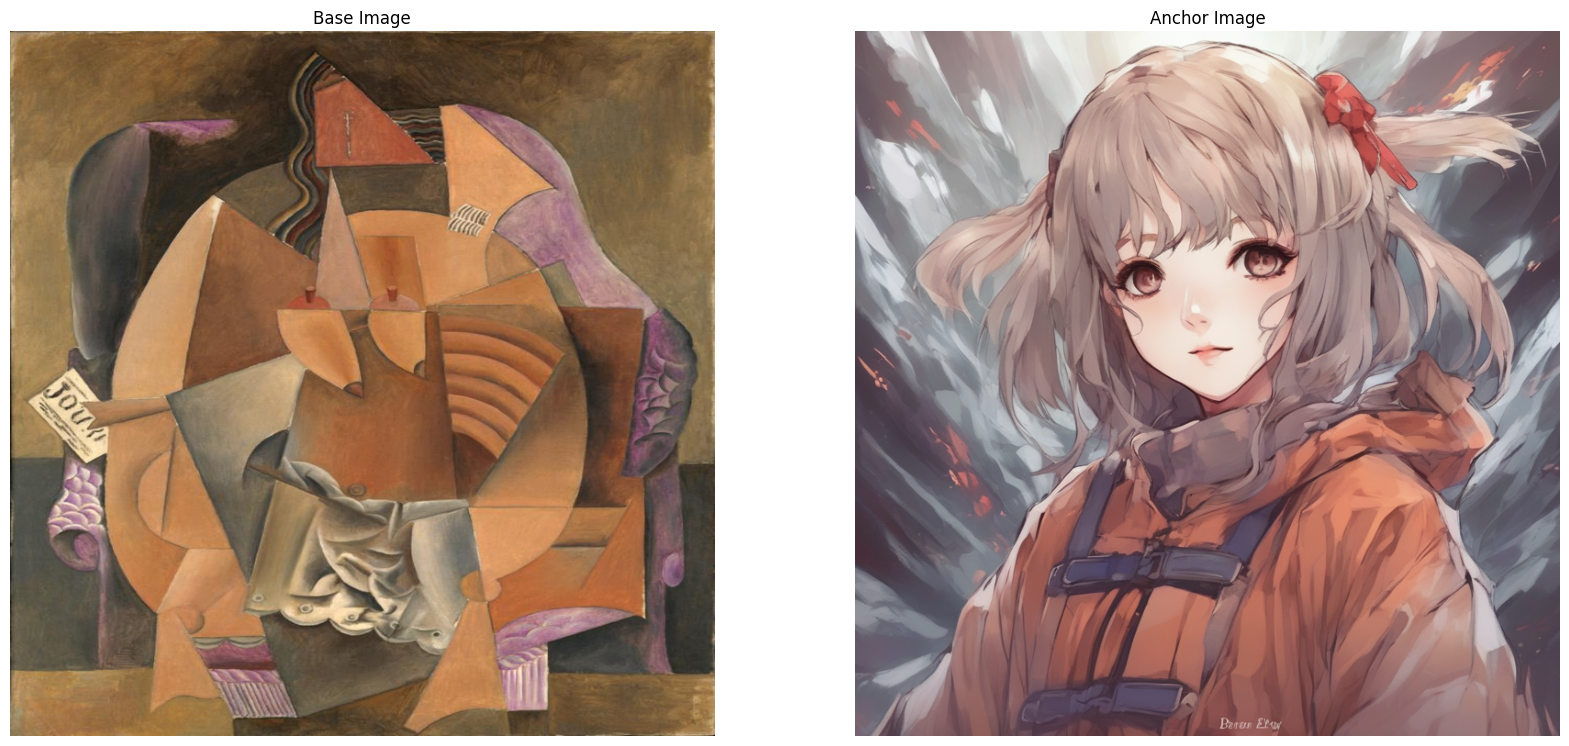

In [ ]:
show_tensor_imgs(torch.cat([base_imgs, anchor_imgs], axis=0), labels=["Base Image", "Anchor Image"])

In [ ]:
# Find mean and stdev of our images to normalize
def get_stats(imgs):
  return imgs.mean(dim=(0, 2, 3)), imgs.std(dim=(0, 2, 3))
normalize = transforms.Normalize(*get_stats(base_imgs))
lpips = LPIPS(net="vgg").cuda()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
vae = AutoencoderKL.from_pretrained(
  "stabilityai/stable-diffusion-2",
  subfolder="vae",
  torch_dtype=torch.float16,
  use_safetensors=True
).to("cuda")

def image_encoder(im):
  torch.cuda.empty_cache()
  if len(im.shape) < 4:
    im = im.unsqueeze(0)
  latent = vae.encode(im * 2 - 1)
  latent = vae.config.scaling_factor * latent.latent_dist.sample()
  if len(im.shape) < 4:
    latent = latent.squeeze()
  return latent

In [ ]:
def show_latent_imgs(latents, labels=None, captions=None):
  weights = (
    (60, -60, 25, -70),
    (60,  -5, 15, -50),
    (60,  10, -5, -35)
  )

  weights_tensor = torch.t(torch.tensor(weights, dtype=latents.dtype).to(latents.device))
  biases_tensor = torch.tensor((150, 140, 130), dtype=latents.dtype).to(latents.device)
  rgb_tensor = (torch.einsum("...lxy,lr -> ...rxy", latents, weights_tensor) + biases_tensor.unsqueeze(-1).unsqueeze(-1)) / 255
  show_tensor_imgs(rgb_tensor.clamp(0, 1), labels=labels, captions=captions)

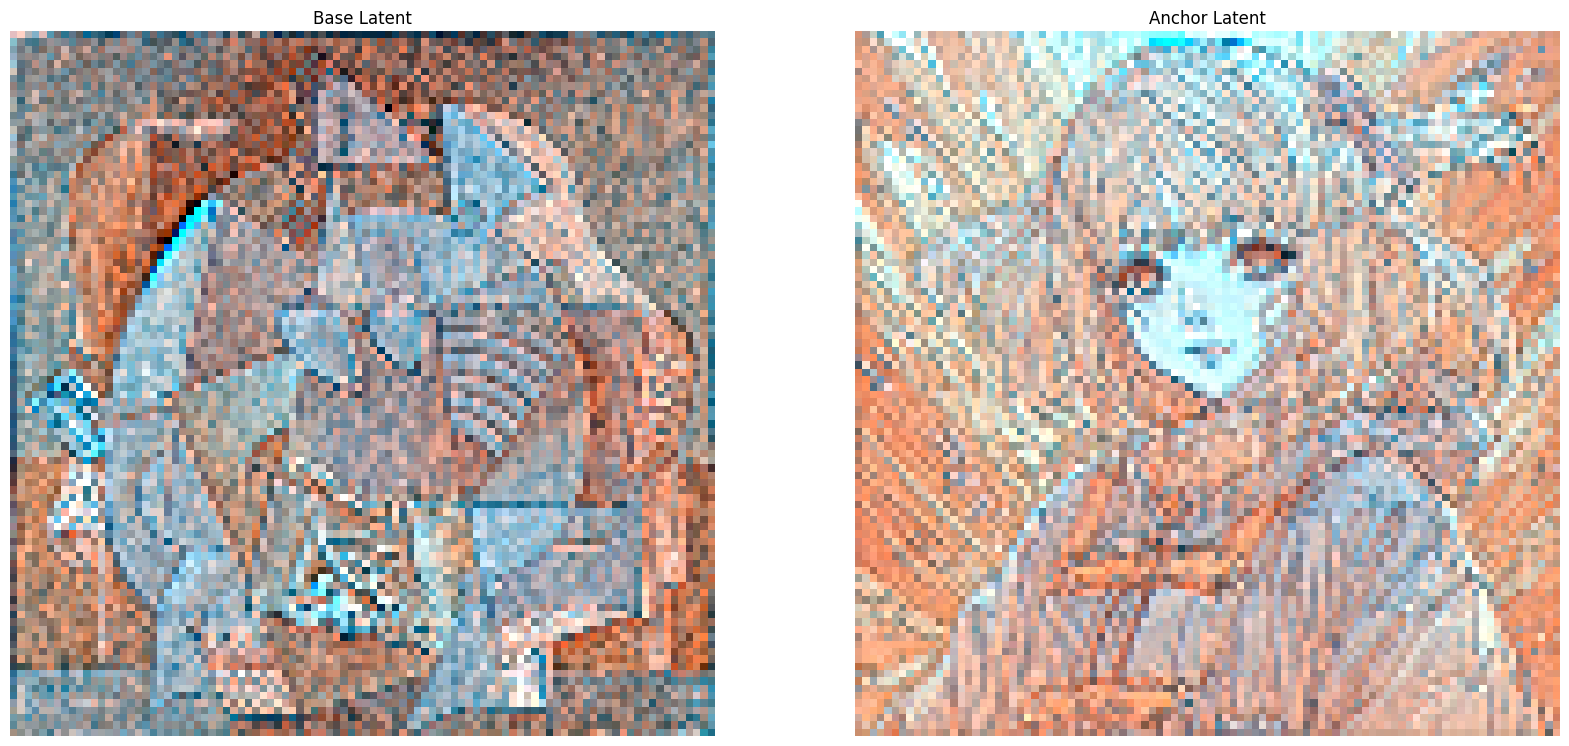

In [ ]:
# Display our images in latent space
with torch.no_grad():
  base_latents = image_encoder(base_imgs.cuda())
  anchor_latents = image_encoder(anchor_imgs.cuda())
show_latent_imgs(torch.cat([base_latents, anchor_latents], axis=0), labels=["Base Latent", "Anchor Latent"])

# Poison Images

Define and run our optimization metrics and poisoning procedure

In [ ]:
def L2_norm(a, b):
  assert a.size(0) == b.size(0), "batches are different sizes"
  return (a - b).view(a.size(0),-1).norm(p=2, dim=1)

def lpips_norm(a, b):
  assert a.size(0) == b.size(0), "batches are different sizes"
  return torch.tensor([lpips(a[i], b[i]) for i in range(a.size(0))]).cuda()

def to_stat(t):
  return t.detach().cpu().numpy()

def estimate_noise(a):
  _, _, h, w = a.shape
  conv2d = torch.nn.Conv2d(3, 3, 3, dtype=torch.float16).cuda()
  sigma = torch.mean(torch.abs(conv2d(a)), dim=(1, 2, 3)) * 16
  return sigma * math.sqrt(0.5 * math.pi) / (6 * 3)

gaussian_blur_transform = transforms.Compose([
  transforms.ConvertImageDtype(torch.float32),
  transforms.GaussianBlur(kernel_size=(5, 9), sigma=(9, 9)),
  transforms.ConvertImageDtype(torch.float16)
])

def nightshade_loss(alpha=100, p=0.07):
  def loss_fn(base, anchor, cur):
    anchor_dist = L2_norm(image_encoder(normalize(cur)), anchor)
    percep_dist = lpips_norm(base, cur)
    loss = anchor_dist + alpha * torch.clamp(percep_dist - p, min=0)
    return loss, (to_stat(anchor_dist).mean(), to_stat(percep_dist).mean())
  return loss_fn

def gaussproof_nightshade_loss(denoise_fn, alpha=100, p=0.07):
  def loss_fn(base, anchor, cur):
    anchor_dist = L2_norm(image_encoder(normalize(denoise_fn(cur))), anchor)
    percep_dist = lpips_norm(base, cur)
    loss = anchor_dist + alpha * torch.clamp(percep_dist - p, min=0)
    return loss, (to_stat(anchor_dist).mean(), to_stat(percep_dist).mean())
  return loss_fn

def noisy_nightshade_loss(noise_metric, alpha=100, p=0.07, beta=100):
  def loss_fn(base, anchor, cur):
    anchor_dist = L2_norm(image_encoder(normalize(cur)), anchor)
    percep_dist = lpips_norm(base, cur)
    noise = estimate_noise(cur)
    loss = anchor_dist + alpha * torch.clamp(percep_dist - p, min=0) + beta * noise
    return loss, (to_stat(anchor_dist).mean(), to_stat(percep_dist).mean(), to_stat(noise).mean())
  return loss_fn

In [ ]:
def poison_images(image_encoder, loss_fn, img_base, img_anchor, iters=100, lr=0.0005):
  # Free as much cuda memory as possible
  gc.collect()
  torch.cuda.empty_cache()

  img_base, img_anchor = img_base.cuda(), img_anchor.cuda()
  assert img_base.shape == img_anchor.shape and img_base.shape[1:] == (3, IMAGE_SIZE, IMAGE_SIZE), f"images should be 3x{IMAGE_SIZE}x{IMAGE_SIZE}"

  bs = img_base.size(0)
  device = img_base.device

  with torch.no_grad():
    embedding_targets = image_encoder(normalize(img_anchor))

  X_adv = img_base.clone().detach()
  X_adv.data = X_adv.data.clamp(0, 1)
  X_adv.requires_grad_(True)

  optimizer = optim.SGD([X_adv], lr=lr)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(iters * 0.5)], gamma=0.5)

  loss_best = 1e8 * torch.ones(bs).to(device)
  X_adv_best = torch.rand(*img_base.shape).to(device)

  # keep track of loss progress for graphing purposes
  prog = []

  for i in tqdm(range(iters)):
    loss, prog_iter = loss_fn(img_base, embedding_targets, X_adv)

    if torch.any(loss < loss_best):
      best_idx = loss < loss_best
      loss_best[best_idx] = loss.detach().clone()[best_idx].cpu()
      X_adv_best = X_adv.detach().clone()[best_idx].cpu()
      prog.append((i,) + prog_iter)

    loss = loss.sum()
    optimizer.zero_grad()
    loss.backward()

    X_adv.grad = torch.sign(X_adv.grad)
    optimizer.step()
    scheduler.step()
    X_adv.data = X_adv.data.clamp(0, 1)
    X_adv.grad = None

    if torch.isnan(loss):
      print(f"Encountered NaN loss at iteration {i}")
      break

  with torch.no_grad():
    print(f"\nBest total loss: {loss_best.mean().item():.4f}")

  return X_adv_best.detach().cpu(), loss_best.cpu(), np.array(prog)

In [ ]:
def display_poison_prog(prog, X_adv, title="Poisoning Statistics"):
  fig = plt.figure(constrained_layout=True, figsize=(12, 5))
  axs = fig.subplot_mosaic([["Left", "TopRight"], ["Left", "BottomRight"]],
                           gridspec_kw={"width_ratios": [1, 2]})
  # Prog columns: [iter #, dist in latent space, perceptual dist]
  efficacy = 1 - prog[:, 1] / prog[0, 1]
  axs["TopRight"].plot(prog[:, 0], efficacy)
  axs["TopRight"].set_xlabel("Iteration")
  axs["TopRight"].set_ylabel("Efficacy")
  axs["TopRight"].set_ylim((0, 1))

  axs["BottomRight"].plot(prog[:, 0], prog[:, 2])
  axs["BottomRight"].set_xlabel("Iteration")
  axs["BottomRight"].set_ylabel("Perceptual Distance")

  show_tensor_imgs(X_adv[0], ax=axs["Left"])

  fig.suptitle(f"{title} over {int(np.max(prog[:, 0]) + 1)} Iterations")

  plt.show()

100%|██████████| 200/200 [00:57<00:00,  3.48it/s]



Best total loss: 284.5000


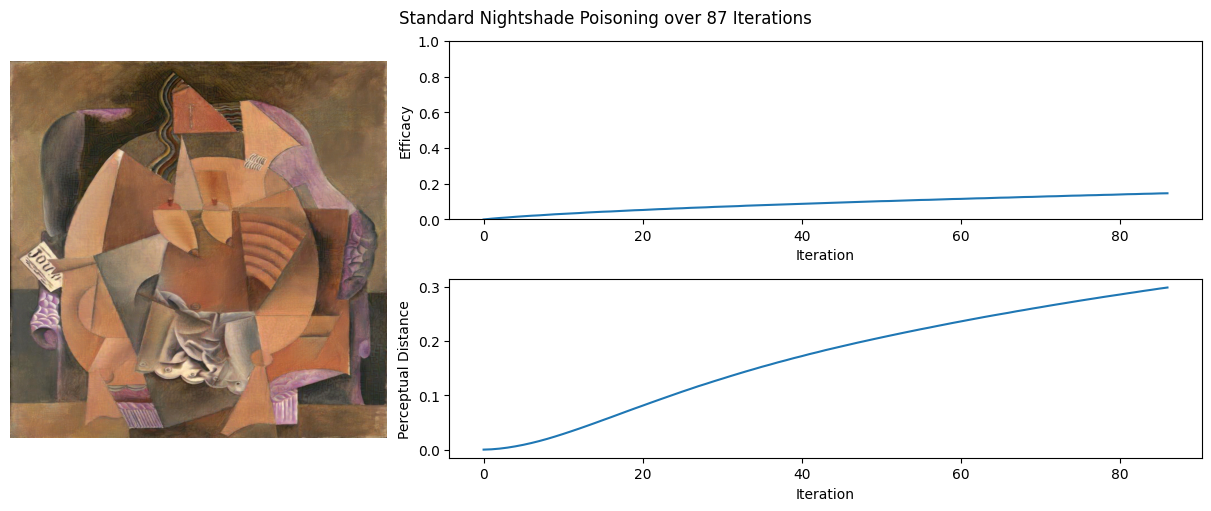

In [ ]:
ns_poisoned, loss_best, ns_prog = poison_images(image_encoder, nightshade_loss(alpha=500, p=0.3), base_imgs, anchor_imgs, iters=200)
display_poison_prog(ns_prog, ns_poisoned, title="Standard Nightshade Poisoning")

100%|██████████| 200/200 [00:57<00:00,  3.48it/s]



Best total loss: 277.0362


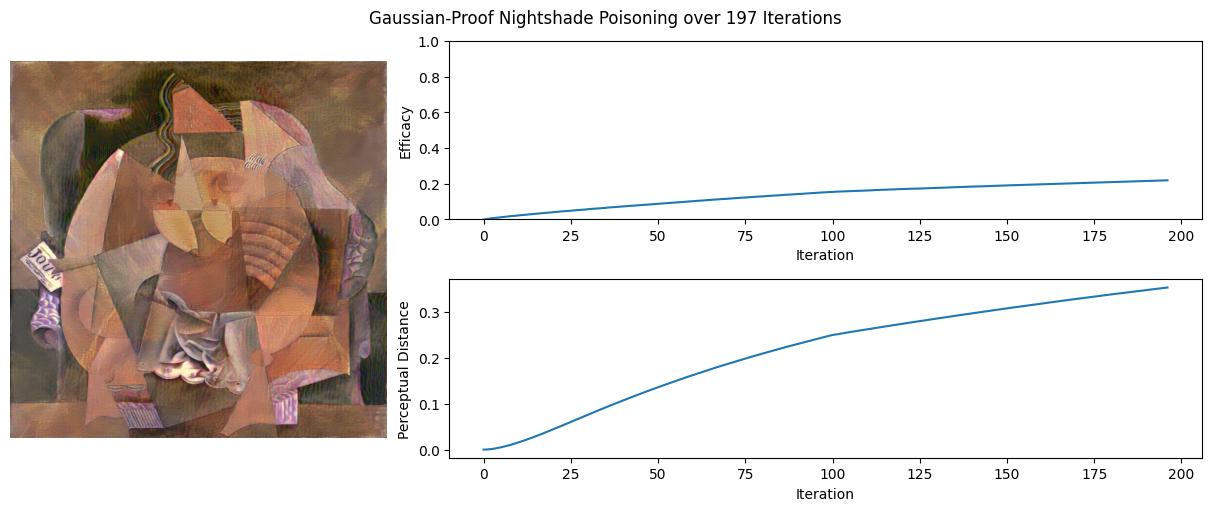

In [ ]:
gpns_poisoned, loss_best, gpns_prog = poison_images(image_encoder, gaussproof_nightshade_loss(gaussian_blur_transform, alpha=200, p=0.3), base_imgs, anchor_imgs, iters=200)
display_poison_prog(gpns_prog, gpns_poisoned, title="Gaussian-Proof Nightshade Poisoning")

100%|██████████| 200/200 [00:57<00:00,  3.48it/s]



Best total loss: 343.0268


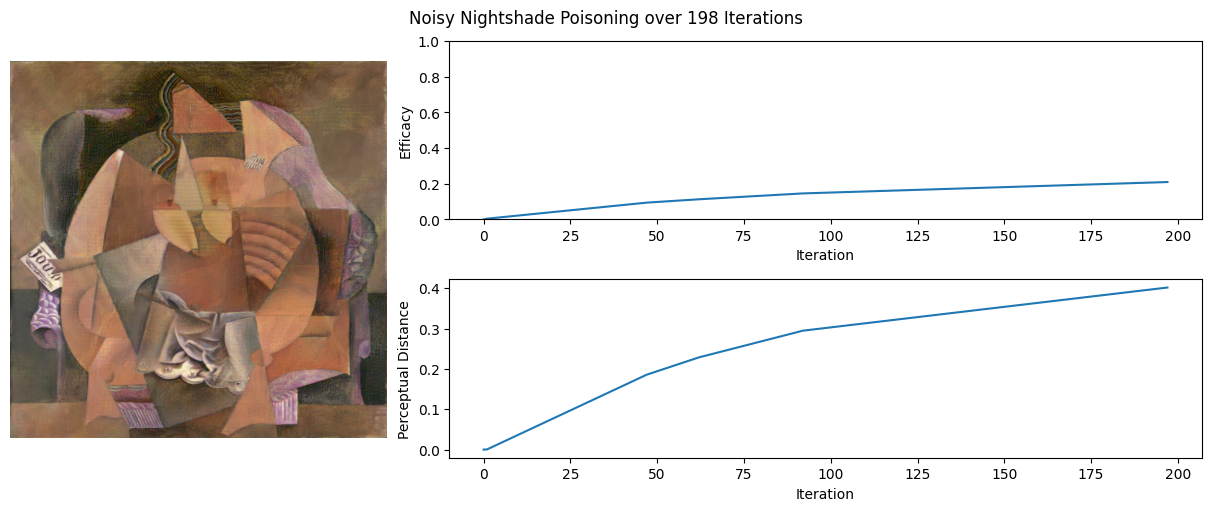

In [ ]:
nns_poisoned, loss_best, nns_prog = poison_images(image_encoder, noisy_nightshade_loss(estimate_noise, alpha=200, beta=1000, p=0.3), base_imgs, anchor_imgs, iters=200)
display_poison_prog(nns_prog, nns_poisoned, title="Noisy Nightshade Poisoning")

# Postprocessing and Results

Generate graphs and compare our different poisoning methods

In [ ]:
# Utils for displaying residuals and latent residuals
def get_residual(poisoned, original):
  return (poisoned - original + 1) / 2

def generate_dist_cap(poisoned, original, dist_metric, device="cpu"):
  dists = []
  for p in poisoned:
    dists.append(dist_metric(p.unsqueeze(0).to(device), original.to(device)).cpu())
  return [f"dist = {d.item():.2f}" for d in dists]

def generate_efficacy_cap(poisoned, original, min_ef):
  dists = []
  for p in poisoned:
    dists.append(L2_norm(p.unsqueeze(0), original))
  return [f"efficacy = {int((1 - d.item() / min_ef) * 100)}%" for d in dists]

def show_residual_imgs(poisoned, original, is_latent=False, labels=None, captions=None):
  res = get_residual(poisoned, original)
  res_mean, res_std = res.mean(dim=(0, 2, 3)), res.std(dim=(0, 2, 3))
  res_normalize = transforms.Normalize(res_mean, res_std)
  if is_latent:
    show_latent_imgs(res_normalize(res), labels=labels, captions=captions)
  else:
    captions = generate_dist_cap(poisoned, original, lpips_norm, device="cuda")
    show_tensor_imgs(res_normalize(res), labels=labels, captions=captions)

def show_latent_residuals(poisoned, anchor, min_ef, labels=None):
  with torch.no_grad():
    latent_poisoned = image_encoder(poisoned.cuda()).cpu()
    latent_anchor = image_encoder(anchor.cuda()).cpu()
  captions = generate_efficacy_cap(latent_poisoned, latent_anchor, min_ef)
  show_residual_imgs(latent_poisoned, latent_anchor, is_latent=True, labels=labels, captions=captions)

In [ ]:
# Use to denoise poisoned images
def denoise_transform(t):
  if len(t.shape) < 4:
    t = t.unsqueeze(0)
  denoised_tens = []
  for im in t:
    np_img = np.ubyte(cv2.cvtColor(np.float32(im.permute(1, 2, 0).numpy() * 255), cv2.COLOR_BGR2RGB))
    denoised = cv2.cvtColor(cv2.fastNlMeansDenoisingColored(np_img, None, 20, 20, 7, 20), cv2.COLOR_RGB2BGR)
    denoised_tens.append((torch.tensor(denoised).permute(2, 0, 1).to(torch.float16) / 255).unsqueeze(0))
  return torch.cat(denoised_tens, axis=0).squeeze()

In [ ]:
poisoned_raw_and_denoised = torch.cat([
    torch.cat([ns_poisoned, gpns_poisoned, nns_poisoned], axis=0),
    denoise_transform(torch.cat([ns_poisoned, gpns_poisoned, nns_poisoned], axis=0))
], axis=0)

labels = ["Standard Poisoned", "Gaussian-Proof Poisoned", "Noisy Poisoned", "Standard Poisoned (DN)", "Gaussian-Proof Poisoned (DN)", "Noisy Poisoned (DN)"]

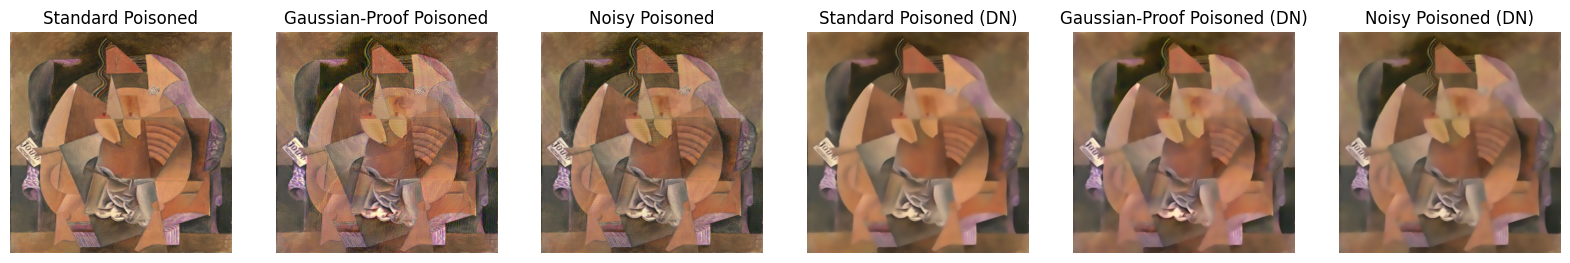

In [ ]:
show_tensor_imgs(poisoned_raw_and_denoised, labels=labels)

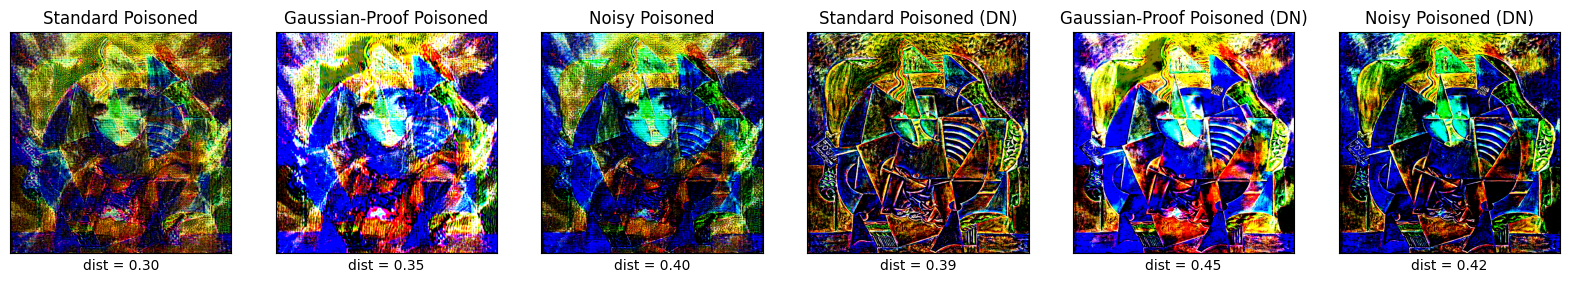

In [ ]:
show_residual_imgs(poisoned_raw_and_denoised, base_imgs, labels=labels)

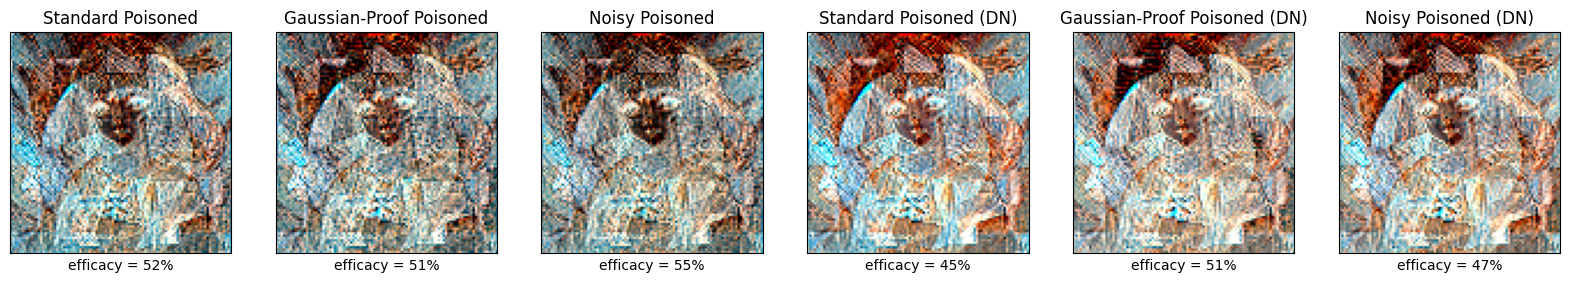

In [ ]:
show_latent_residuals(poisoned_raw_and_denoised, anchor_imgs, ns_prog[0, 1], labels=labels)